In [1]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPProcessor, CLIPModel

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

from tqdm import tqdm
from customCLIP import customCLIP
import config

/usr/local/Caskroom/miniconda/base/envs/EuroSAT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1: Zero-Shot Classification with Foundation Models

### Objective
The goal of this task is to explore the **EuroSAT dataset** and apply zero-shot classification using a **pre-trained CLIP model**. We will evaluate how well CLIP can classify satellite images using textual descriptions without any dataset-specific training.


## Data: EuroSAT Dataset

### Overview
The **EuroSAT dataset** consists of RGB satellite images categorized into 10 land cover classes. Let's analyze the structure.

Classes found: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Modified classes:  ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'Sea Lake']
Class distribution: {'AnnualCrop': 3000, 'Forest': 3000, 'HerbaceousVegetation': 3000, 'Highway': 2500, 'Industrial': 2500, 'Pasture': 2000, 'PermanentCrop': 2500, 'Residential': 3000, 'River': 2500, 'SeaLake': 3000}


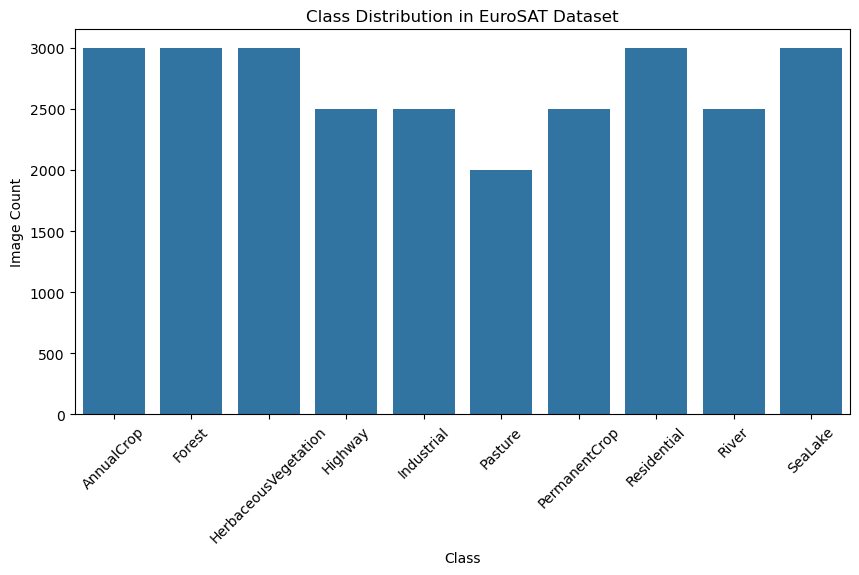

In [2]:
# classes check
dataset_path = "2750/"

CLASSES = sorted([cls for cls in os.listdir(dataset_path) if not cls.startswith('.')])
MOD_CLASSES = [config.CLASSNAME_DICT[c] for c in CLASSES]

print(f"Classes found: {CLASSES}")

print("Modified classes: ", MOD_CLASSES)

class_counts = {cls: len(glob(os.path.join(dataset_path, cls, "*.jpg"))) for cls in CLASSES}
print(f"Class distribution: {class_counts}")

df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Class", y="Image Count", data=df_counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in EuroSAT Dataset")
plt.show()


In [3]:
# channels and resolution check
image_info = []

for cls in CLASSES:
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]
    img = Image.open(img_path)
    image_info.append((cls, img.mode, img.size))

df_info = pd.DataFrame(image_info, columns=["Class", "Mode", "Resolution"])

print(df_info)

unique_modes = df_info["Mode"].unique()
unique_resolutions = df_info["Resolution"].unique()

print(f"\nUnique image modes found: {unique_modes}")
print(f"Unique image resolutions found: {unique_resolutions}")


                  Class Mode Resolution
0            AnnualCrop  RGB   (64, 64)
1                Forest  RGB   (64, 64)
2  HerbaceousVegetation  RGB   (64, 64)
3               Highway  RGB   (64, 64)
4            Industrial  RGB   (64, 64)
5               Pasture  RGB   (64, 64)
6         PermanentCrop  RGB   (64, 64)
7           Residential  RGB   (64, 64)
8                 River  RGB   (64, 64)
9               SeaLake  RGB   (64, 64)

Unique image modes found: ['RGB']
Unique image resolutions found: [(64, 64)]


#### **Dataset Structure**
- Folder: `2750/`
- Subfolders (each corresponding to a class):
  - `AnnualCrop/`
  - `Forest/`
  - `HerbaceousVegetation/`
  - `Highway/`
  - `Industrial/`
  - `Pasture/`
  - `PermanentCrop/`
  - `Residential/`
  - `River/`
  - `SeaLake/`
- Each subfolder contains from 2000 to 3000 images named as `{class_name}_{i}.jpg` (e.g., `Forest_102.jpg`). So overall the different classes are quite balanced.
- Images are repesentes as RGB satellite images with 64×64 pixels resolution.

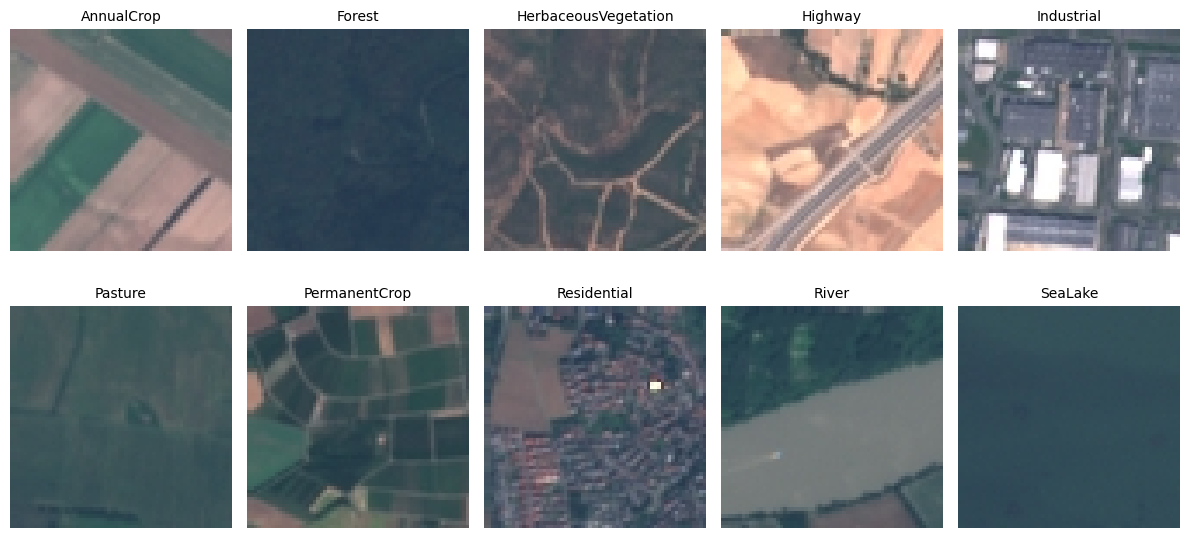

In [4]:
# visualization
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, cls in enumerate(CLASSES):
    img_path = glob(os.path.join(dataset_path, cls, "*.jpg"))[0]  
    img = Image.open(img_path)

    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(cls, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


Many of them looks quite similar such that it would be difficult to be classified for also for a human.

At the moment, "Highway" and "River" looks like may be confused, as well as the "Residential" and "Industrial" classes or the "AnnualCrop" and "Pasture".

## CLIP: Zero-Shot Classification with Foundation Models
In this section, we implement zero-shot classification using **CLIP** to classify EuroSAT satellite images without dataset-specific training.  

We start by defining a function that classifies a single image, ensuring efficiency and flexibility. Then, we apply it to a single class before running it on the entire dataset to evaluate performance across all land cover types.  

To determine the best approach, we test four configurations, varying image rescaling and prompting to analyze their impact on classification accuracy.


In [5]:
customclip = customCLIP(model_name="openai/clip-vit-base-patch32")

### Single Image Classification 
We define a function that loads CLIP once and allows for customization:  
- **Resizing**: Optional rescaling to 224x224, CLIP’s expected input size.  
- **Prompting**: Either `"A satellite image of <class>"` or just the class name.  
- **Output Format**: Return either the best class or all probabilities for deeper analysis.  

These options allow us to test four setups, combining different prompts and rescaling choices to evaluate their impact on classification accuracy.


### Single-Class Analysis  
Before testing the full dataset, we apply CLIP to one class (`SeaLake`).  

We expect some correct classifications, but also errors due to CLIP's lack of satellite-specific training. This helps identify potential challenges before scaling up.

In [6]:
test_class_name = "SeaLake"

results = customclip.single_class_analysis(test_class_name)

Classifying SeaLake batches: 100%|██████████| 47/47 [00:19<00:00,  2.44it/s]


In [7]:
print(set([r.item() for r in results["y_pred"]]))
print(set([r.item() for r in results["y_true"]]))

{0, 1, 3, 4, 6, 7, 8, 9}
{9}


Zero-Shot Classification Accuracy for 'SeaLake': 19.07%


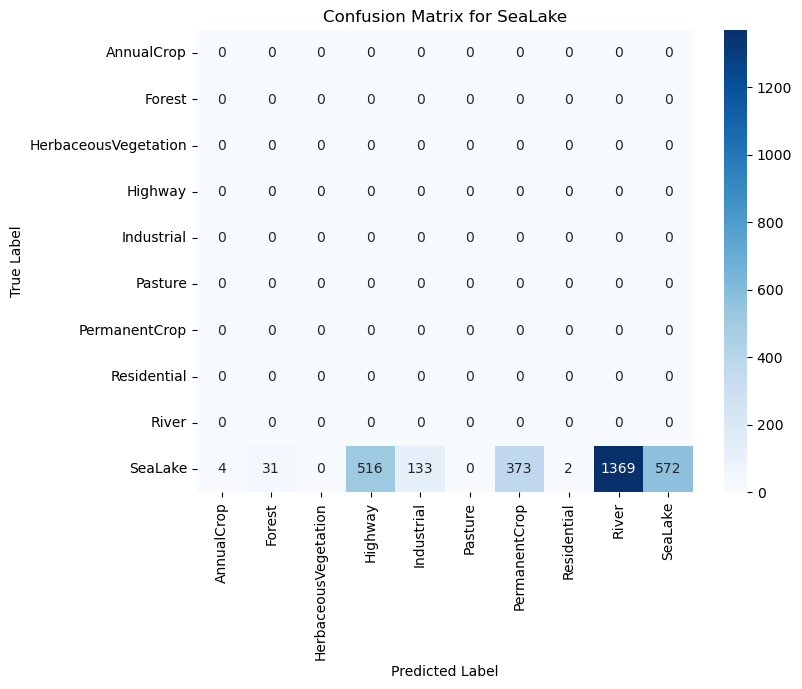

In [8]:
sealake_accuracy = results["accuracy"]
sealake_cm = results["confusion_matrix"]

print(f"Zero-Shot Classification Accuracy for '{test_class_name}': {sealake_accuracy * 100:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap(sealake_cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {test_class_name}")
plt.show()

### Whole Dataset Classification
We now classify the entire dataset using the four different configurations.  

By analyzing overall accuracy, per-class accuracy, and confusion matrices**, we aim to determine which approach works best for zero-shot land cover classification with CLIP.


In [13]:
def visualize_results(results_df, full_prompt, modified_class):
    if full_prompt:
        fp_txt = "Full Prompt Context"
    else:
        fp_txt = "No Prompt Context"
    if modified_class:
        cls_txt = "Modified Class Names"
    else:
        cls_txt = "Original Class Names"
    overall_accuracy = np.mean(results_df["accuracy"])
    overall_cm = results_df["confusion_matrix"].sum()

    print(f"\nOverall Accuracy ({fp_txt} + {cls_txt}): {100*overall_accuracy:.2f}%\n")
    print("Accuracy per Class:")
    for cls, acc in results_df["accuracy"].items():
        print(f"  - {CLASSES[cls]}: {100*acc:.2f}%")

    plt.figure(figsize=(10, 8))
    sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({fp_txt} + {cls_txt})")
    plt.show()


#### 1) Full Context + Original Class Names

In [15]:
customclip_1 = customCLIP(full_prompt=True, modify=False)
results_df_1 = customclip_1.multi_class_analysis()

Classifying SeaLake batches: 100%|██████████| 47/47 [00:18<00:00,  2.49it/s]



Overall Accuracy (Full Prompt Context + Original Class Names): 38.29%

Accuracy per Class:
  - AnnualCrop: 13.77%
  - Forest: 39.80%
  - HerbaceousVegetation: 0.17%
  - Highway: 61.68%
  - Industrial: 72.44%
  - Pasture: 7.45%
  - PermanentCrop: 62.44%
  - Residential: 85.50%
  - River: 20.56%
  - SeaLake: 19.07%


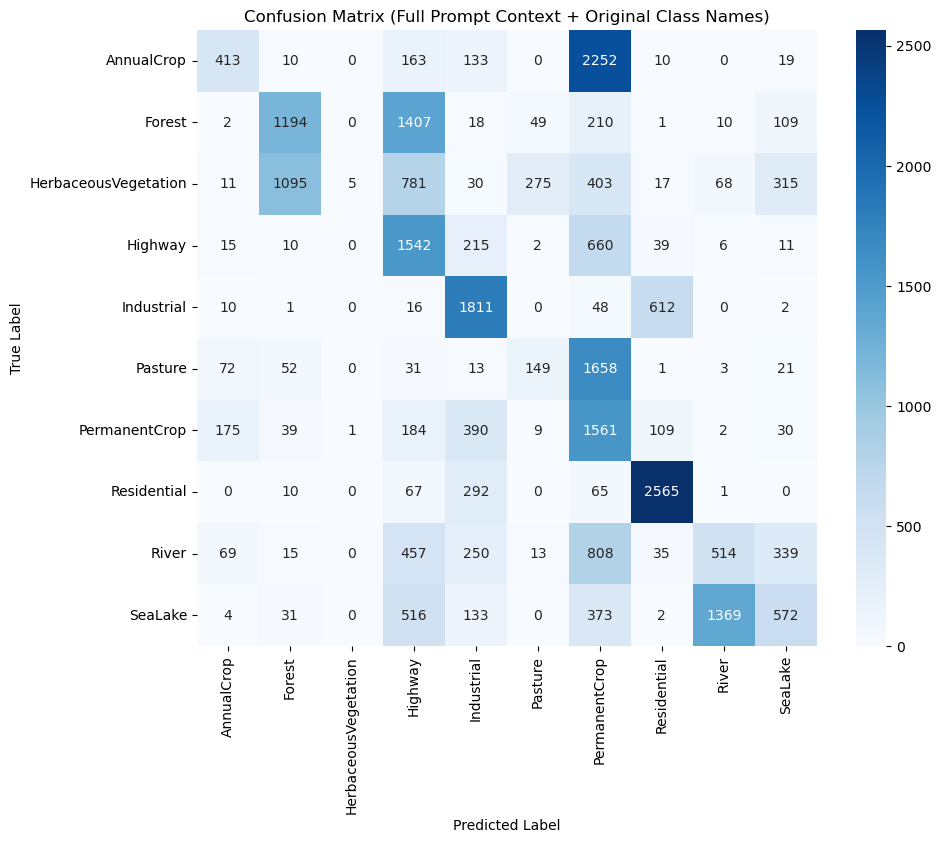

In [16]:
visualize_results(results_df_1, full_prompt=True, modified_class=False)


#### 2) No Context Prompt + Original Class Names

In [18]:
customclip_2 = customCLIP(full_prompt=False, modify=False)
results_df_2 = customclip_2.multi_class_analysis()

Classifying SeaLake batches: 100%|██████████| 47/47 [00:18<00:00,  2.56it/s]



Overall Accuracy (No Prompt Context + Original Class Names): 35.18%

Accuracy per Class:
  - AnnualCrop: 28.63%
  - Forest: 17.00%
  - HerbaceousVegetation: 21.93%
  - Highway: 49.08%
  - Industrial: 4.48%
  - Pasture: 14.60%
  - PermanentCrop: 31.08%
  - Residential: 88.90%
  - River: 41.52%
  - SeaLake: 54.60%


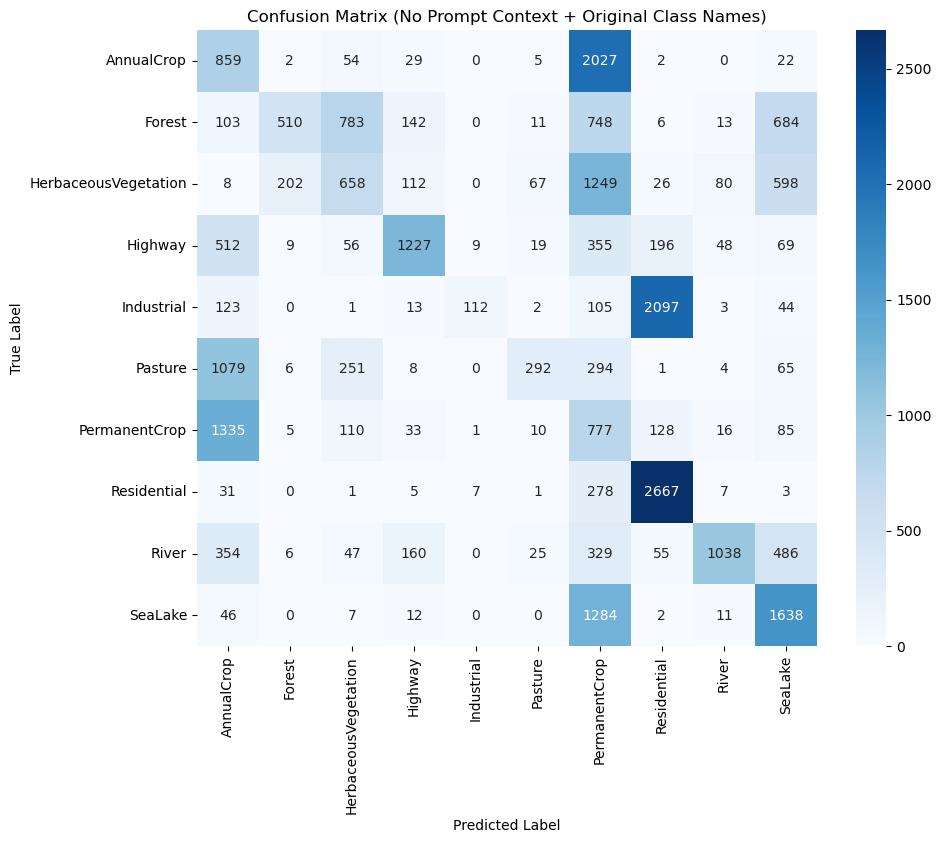

In [19]:
visualize_results(results_df_2, full_prompt=False, modified_class=False)

#### 3) Full Context with Modified Classes

In [20]:
customclip_3 = customCLIP(full_prompt=True, modify=True)
results_df_3 = customclip_3.multi_class_analysis()

Classifying SeaLake batches: 100%|██████████| 47/47 [00:18<00:00,  2.59it/s]



Overall Accuracy (Full Prompt Context + Modified Class Names): 39.66%

Accuracy per Class:
  - AnnualCrop: 29.83%
  - Forest: 43.20%
  - HerbaceousVegetation: 0.07%
  - Highway: 68.16%
  - Industrial: 72.68%
  - Pasture: 39.85%
  - PermanentCrop: 25.32%
  - Residential: 86.40%
  - River: 25.04%
  - SeaLake: 6.03%


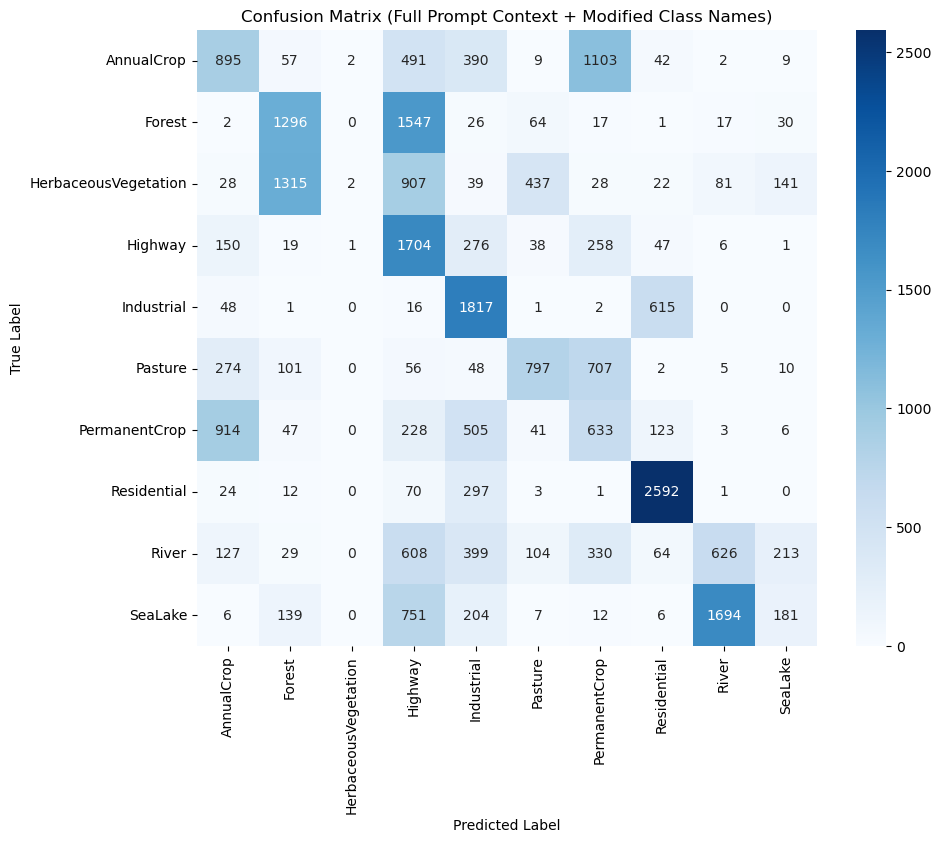

In [21]:
visualize_results(results_df_3, full_prompt=True, modified_class=True)

#### 4) No Context with Modified Classes

In [22]:
customclip_4 = customCLIP(full_prompt=False, modify=True)
results_df_4 = customclip_4.multi_class_analysis()

Classifying SeaLake batches: 100%|██████████| 47/47 [00:18<00:00,  2.50it/s]



Overall Accuracy (No Prompt Context + Modified Class Names): 35.45%

Accuracy per Class:
  - AnnualCrop: 0.10%
  - Forest: 42.00%
  - HerbaceousVegetation: 0.37%
  - Highway: 52.64%
  - Industrial: 6.08%
  - Pasture: 19.05%
  - PermanentCrop: 73.08%
  - Residential: 96.97%
  - River: 38.28%
  - SeaLake: 25.93%


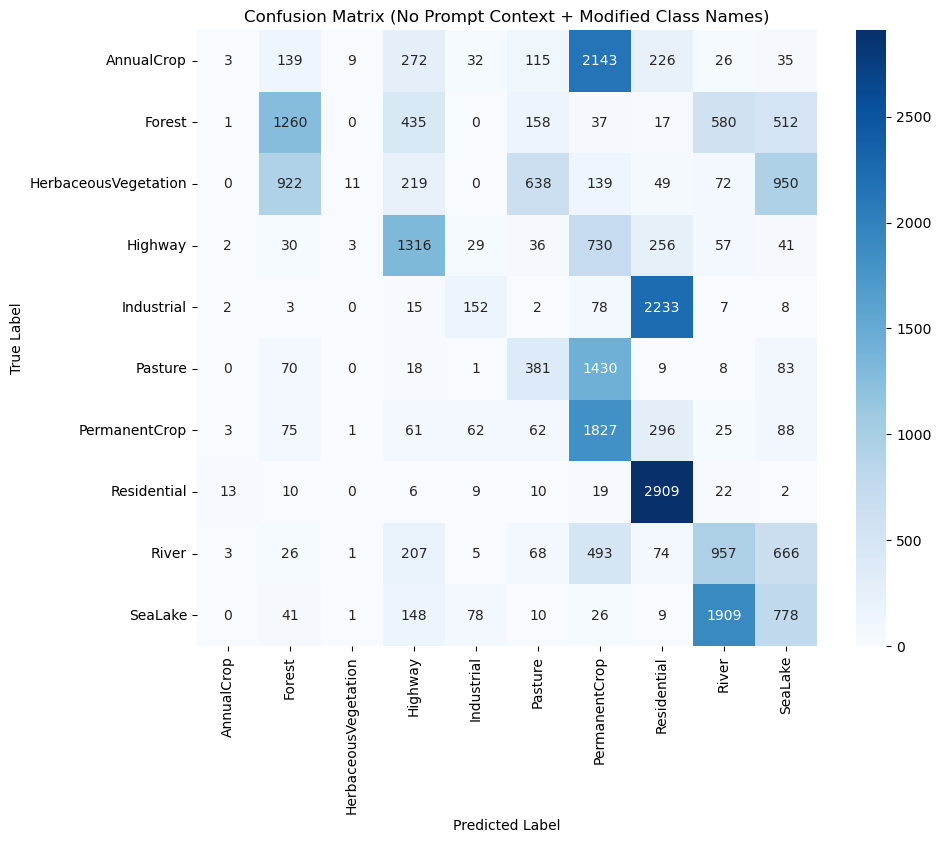

In [23]:
visualize_results(results_df_4, full_prompt=False, modified_class=True)

#### Results Analysis

In [24]:
def compare_class_accuracies(results):
    """
    Compare accuracy results from two different configurations.

    Parameters:
    - acc_1: Dictionary of class accuracies for first configuration.
    - acc_2: Dictionary of class accuracies for second configuration.
    - label_1: Label for first configuration (string).
    - label_2: Label for second configuration (string).
    """
    accuracies = [result["accuracy"] for result in results]

    acc_values = [[np.average([acc[i] for i in range(10)])] + [acc[i] for i in range(10)] for acc in accuracies]

    x = np.arange(len(CLASSES)+1)

    plt.figure(figsize=(24, 5))

    plt.bar(x - 0.3, acc_values[0], width=0.2, label="Full Prompt + Original Classnames", alpha=0.7)
    plt.bar(x - 0.1, acc_values[1], width=0.2, label="No Prompt + Original Classnames", alpha=0.7)
    plt.bar(x + 0.1, acc_values[2], width=0.2, label="Full Prompt + Modified Classnames", alpha=0.7)
    plt.bar(x + 0.3, acc_values[3], width=0.2, label="No Prompt + Modified Classnames", alpha=0.7)

    plt.xticks(x,  ["Average"] + CLASSES, rotation=45, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title("Comparison of Class Accuracies")
    plt.legend()
    plt.show()


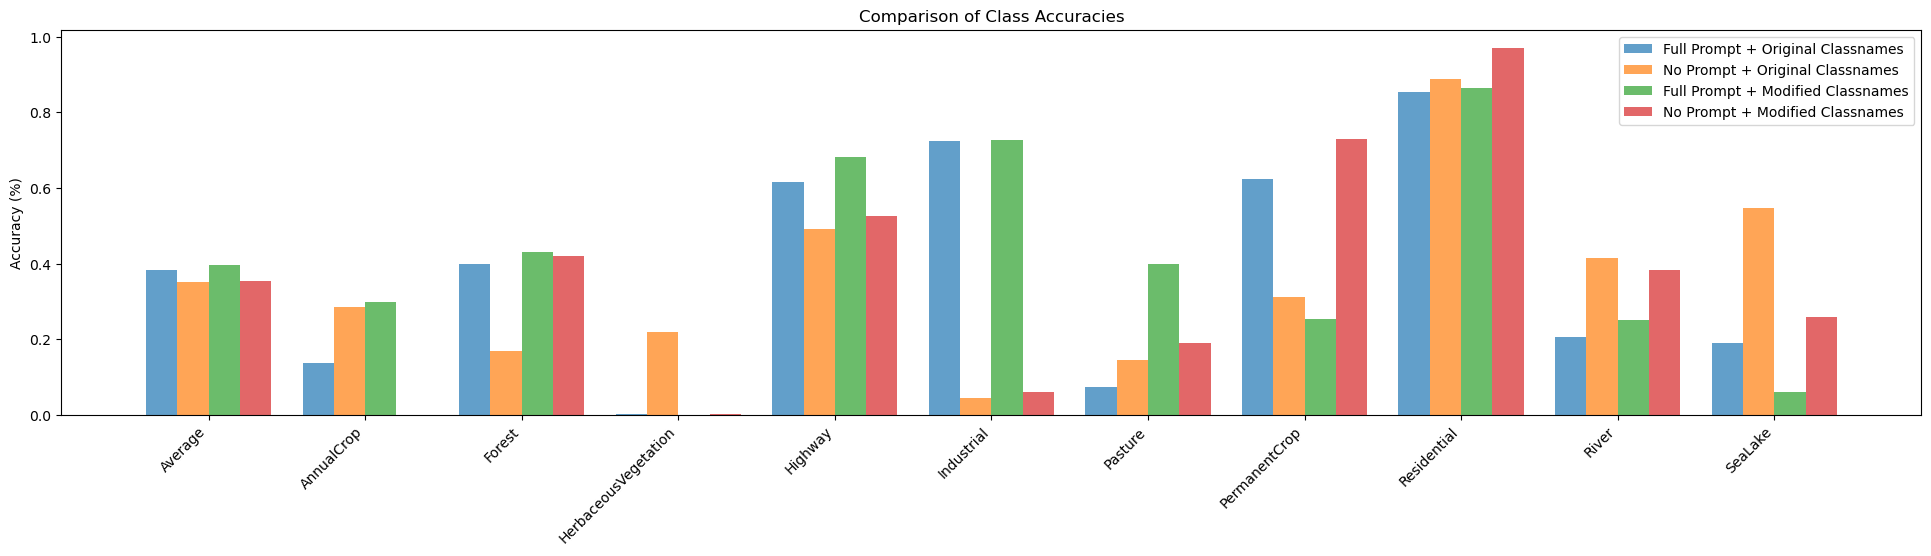

In [25]:
strategy_results = [results_df_1, results_df_2, results_df_3, results_df_4]
compare_class_accuracies(strategy_results)

The results are quite interesting.

The average accuracies across each class are similar between the four strategies - with "Full Prompt + Modified Classnames" having a slight edge. However when we look into each of the classes, we can see some incredibly varying results. 

**Annual Crop**
- Virtually 0% with the 4th strategy
- 2nd and 3rd strategies similar (despite being 'opposite' strategies)

**Forest**
- Similar accuriacies around 40% for all strategies, besides 2nd which has below 20%

**Herbaceous Vegetation**
- Virtually 0% accuracy on all strategies except 2nd, which has above 20%

**Highway**
- Varied accuracies, seem to be favoring using the full prompt

**Industrial**
- Enormous dropoff in accuracies between strategies 1,3 and 2,4
- Favoring using full prompt

**Pasture** 
- Noticeable advantage to using 3rd strategy

**Permanent Crop** 
- Large dropoff in accuracies between strategies 1,4 and 2,3
- Advantage from using 'opposite' strategies

**Residential**
- Overall good accuracies, favor to strategy 4

It is curious that the improvements of some strategies on one class do not at all carry over to other classes. There are also huge discrepencies between some strategies in the same class, like **Herbacious Vegetation**. 

It is counter-intuitive that 'opposite' strategies show similar positive results in **Annual Crop** and **Permanent Crop**.
